In [1]:
import pandas as pd
import numpy as np
import os

ruta_base = '/Users/anapaulaelizondo/Desktop/Cosmos/data/'

# Upload datasets
sales = pd.read_csv(f'{ruta_base}/Total_sales_per_product.csv')
conversion = pd.read_csv(f'{ruta_base}/conversion_rate.csv')

# --- Clean datasets ---
sales = sales.drop(columns=[
    'Nombre del producto', 'Título de variante de producto', 'Ventas brutas', 'Descuentos', 'Devoluciones',
    'Ventas netas', 'Impuestos', 'Ventas totales','SKU de variante de producto'])
sales = sales.rename(columns={
    'Día': 'day', 'Artículos netos vendidos': 'total_sales'})
sales["day"] = pd.to_datetime(sales["day"], format="%d/%m/%y", errors='coerce')
sales = sales.dropna(subset=['day'])
sales['total_sales'] = sales['total_sales'].apply(lambda x: max(x, 0))

# --- Clean  conversion ---
conversion = conversion.drop(columns=[
    'Sesiones con adiciones al carrito', 'Sesiones en las que se llegó a la pantalla de pago', 'Day (previous_period)', 'Sessions (previous_period)',
    'Sessions with cart additions (previous_period)', 'Sessions that reached checkout (previous_period)',
    'Sessions that completed checkout (previous_period)', 'Conversion rate (previous_period)',
    'Sesiones en las que se completó el pago','Tasa de conversión'])
conversion = conversion.rename(columns={'Día': 'day','Sesiones': 'total_sessions'})
conversion["day"] = pd.to_datetime(conversion["day"], format="%Y-%m-%d", errors='coerce')
conversion = conversion.dropna(subset=['day'])

# --- Create combined dataset ---
combined = (pd.merge(sales, conversion, on='day', how='outer')).fillna(0)
combined['conversion_rate'] = (combined['total_sales'] / combined['total_sessions']).fillna(0)
combined['conversion_rate'] = combined['conversion_rate'].round(3)


# Group by day:
combined = (combined.groupby('day', as_index=False).agg({
          'total_sales':   'sum', 'total_sessions':'first'}))

/var/folders/fb/m286qmnn2d9dg79tr96r4_rc0000gn/T/ipykernel_3985/617882684.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Correlation
r = combined['total_sales'].corr(combined['total_sessions'])
print("Pearson r:", r.round(2))

Pearson r: 0.72


In [5]:
import pandas as pd

# 1. Load your merged DataFrame
combined_copy = combined.copy()

# 2. Read inventory CSV
inventory = pd.read_csv(f"{ruta_base}/inventory_summary.csv")

# 3. Convert the date column ("Day") to datetime and rename it
inventory['day'] = pd.to_datetime(inventory['Día'], dayfirst=True)

# 4. Group by day by adding the inventory
inv_daily = (
    inventory
      .groupby('day', as_index=False)
      .agg({'Unidades de inventario finales': 'sum'})
      .rename(columns={'Unidades de inventario finales': 'inventory'})
)

# 5. Make sure the 'day' column in your copy is datetime
combined_copy['day'] = pd.to_datetime(combined_copy['day'])

# 6. Merge to incorporate the new 'inventory' column
combined_copy = (
    combined_copy
      .merge(inv_daily, on='day', how='left')
      .fillna({'inventory': 0}))

# -----------------------------------------------------
# 7. Force inventory = 0 on the indicated dates
dates_to_zero = [
    "01/01/25","02/01/25","03/01/25","04/01/25","05/01/25","06/01/25","07/01/25",
    "08/01/25","09/01/25","10/01/25","11/01/25","12/01/25","13/01/25","14/01/25",
    "15/01/25","16/01/25","17/01/25","18/01/25","19/01/25","20/01/25","21/01/25",
    "22/01/25","23/01/25","24/01/25","25/01/25","26/01/25","27/01/25","28/01/25",
    "29/01/25","30/01/25","31/01/25","01/02/25","02/02/25","03/02/25","04/02/25",
    "05/02/25","06/02/25","07/02/25","08/02/25","09/02/25","10/02/25","11/02/25",
    "12/02/25","13/02/25","14/02/25","15/02/25","16/02/25","17/02/25","18/02/25",
    "19/02/25","20/02/25","21/02/25","22/02/25","23/02/25","24/02/25","25/02/25",
    "26/02/25","27/02/25","28/02/25","01/03/25","02/03/25","03/03/25","04/03/25",
    "05/03/25","06/03/25","07/03/25","08/03/25","09/03/25","10/03/25","11/03/25",
    "12/03/25","13/03/25","14/03/25","15/03/25","16/03/25","17/03/25","18/03/25",
    "19/03/25","20/03/25","21/03/25","22/03/25","23/03/25","24/03/25","25/03/25",
    "26/03/25","27/03/25","28/03/25","29/03/25","30/03/25","31/03/25","01/04/25",
    "02/04/25","03/04/25"
]

zero_days = pd.to_datetime(dates_to_zero, dayfirst=True)

# Make sure that combined_copy['day'] is a datetime
combined_copy['day'] = pd.to_datetime(combined_copy['day'], dayfirst=True)

# Apply the rule: on those dates inventory = 0
combined_copy.loc[ combined_copy['day'].isin(zero_days), 'inventory' ] = 0

# 8. (Optional) Check that it was applied
print(combined_copy.loc[ combined_copy['day'].isin(zero_days), ['day','inventory'] ].drop_duplicates().head())

           day  inventory
204 2025-01-01        0.0
205 2025-01-02        0.0
206 2025-01-03        0.0
207 2025-01-04        0.0
208 2025-01-05        0.0


/var/folders/fb/m286qmnn2d9dg79tr96r4_rc0000gn/T/ipykernel_3985/3117637537.py:10: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  inventory['day'] = pd.to_datetime(inventory['Día'], dayfirst=True)
/var/folders/fb/m286qmnn2d9dg79tr96r4_rc0000gn/T/ipykernel_3985/3117637537.py:48: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  zero_days = pd.to_datetime(dates_to_zero, dayfirst=True)


In [6]:
#DELETE INITIAL DATA WITHOUT SALES

# datetime format validation
combined_copy['day'] = pd.to_datetime(combined_copy['day'], dayfirst=True)

# Filter rows from August 6, 2024 (inclusive)
combined_copy = combined_copy[ combined_copy['day'] >= pd.to_datetime('2024-08-06') ].copy()

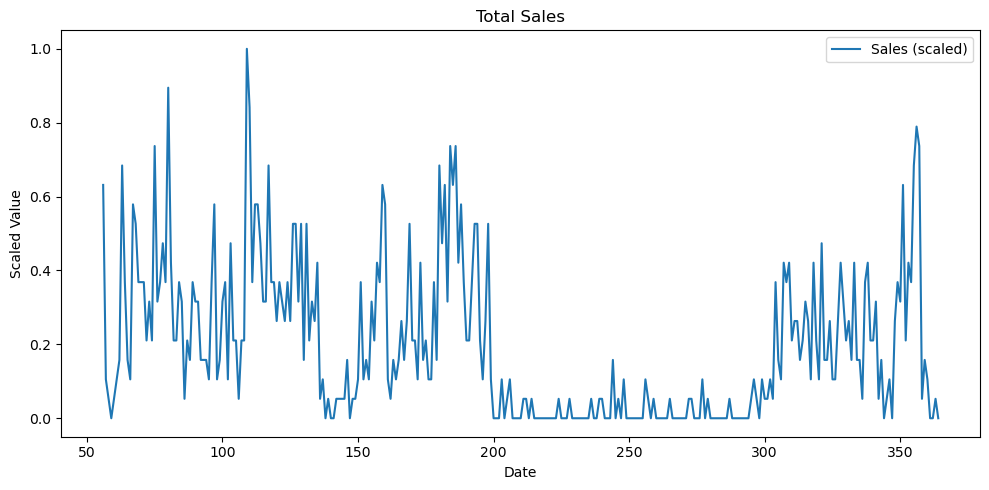

In [7]:
#CHECK INVENTORY DISCREPANCIES AND EXPLAIN THEM

import matplotlib.pyplot as plt

# 1. Extract only the three series
serie = combined_copy[['total_sessions', 'inventory', 'total_sales']].copy()

# 2. Normalization Min–Max
for col in serie.columns:
    min_, max_ = serie[col].min(), serie[col].max()
    serie[col] = (serie[col] - min_) / (max_ - min_)

# 3. Graph
plt.figure(figsize=(10,5))
#plt.plot(serie.index, serie['total_sessions'], label='Sessions (scaled)')
#plt.plot(serie.index, serie['inventory'],    label='Inventory (scaled)')
plt.plot(serie.index, serie['total_sales'],  label='Sales (scaled)')
plt.xlabel('Date')
plt.ylabel('Scaled Value')
plt.title('Total Sales')
plt.legend()
plt.tight_layout()
plt.show()

In [9]:
import pandas as pd

# Part 0: Starting with your combined DataFrame
df = combined_copy.copy()

# 1. Make sure 'day' is a datetime and add it as an index
df['day'] = pd.to_datetime(df['day'], dayfirst=True) 
df = df.set_index('day').sort_index()

# 2. Create the weekday column (0 = Monday … 6 = Sunday)
df['weekday'] = df.index.weekday

# 3. Calculate the average sales and sessions **for all data**, per weekday
means = (
    df
      .groupby('weekday')[['total_sales','total_sessions']]
      .mean()
)
print("Average per weekday:\n", means, "\n")

# 4. Define mask of rows to impute:
# - day in 2025 or later
#    - inventory ≤ 0 o NaN
mask = (df.index.year >= 2025) & ((df['inventory'] <= 0) | (df['inventory'].isna()))
print("Total rows to be imputed:", mask.sum())

# 5. Replace the columns in those rows according to their weekday
df.loc[mask, 'total_sales']    = df.loc[mask, 'weekday'].map(means['total_sales'])
df.loc[mask, 'total_sessions'] = df.loc[mask, 'weekday'].map(means['total_sessions'])

# 6. (Optional) Mark which rows were imputed
df['imputed'] = False
df.loc[mask, 'imputed'] = True

# 7. Final result
combined_imputed = df

Average per weekday:
          total_sales  total_sessions
weekday                             
0           3.977273      550.863636
1           3.977778      524.955556
2           3.409091      510.613636
3           3.181818      459.000000
4           3.568182      451.340909
5           3.454545      510.477273
6           4.568182      583.454545 

Total rows to be imputed: 93


/var/folders/fb/m286qmnn2d9dg79tr96r4_rc0000gn/T/ipykernel_3985/4133592127.py:29: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[510.61363636 459.         451.34090909 510.47727273 583.45454545
 550.86363636 524.95555556 510.61363636 459.         451.34090909
 510.47727273 583.45454545 550.86363636 524.95555556 510.61363636
 459.         451.34090909 510.47727273 583.45454545 550.86363636
 524.95555556 510.61363636 459.         451.34090909 510.47727273
 583.45454545 550.86363636 524.95555556 510.61363636 459.
 451.34090909 510.47727273 583.45454545 550.86363636 524.95555556
 510.61363636 459.         451.34090909 510.47727273 583.45454545
 550.86363636 524.95555556 510.61363636 459.         451.34090909
 510.47727273 583.45454545 550.86363636 524.95555556 510.61363636
 459.         451.34090909 510.47727273 583.45454545 550.86363636
 524.95555556 510.61363636 459.         451.34090909 510.47727273
 583.

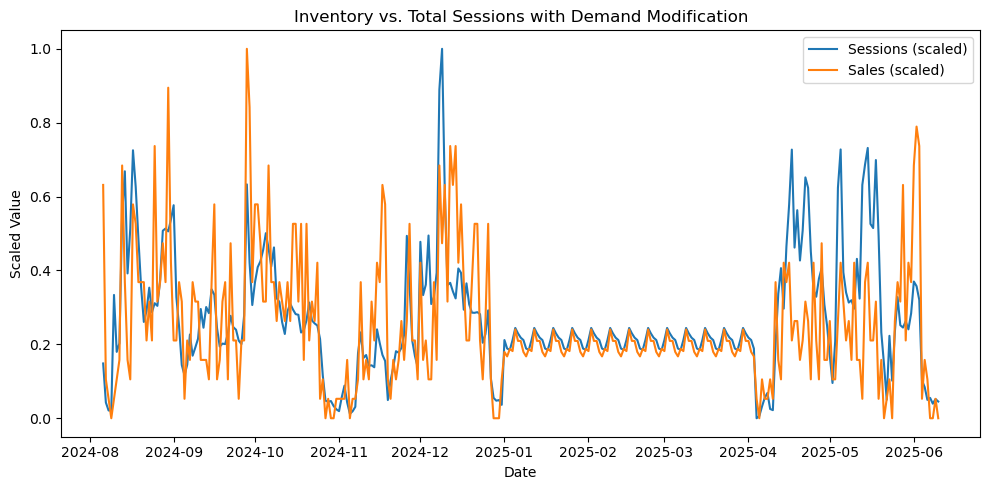

In [10]:
#CHECK INVENTORY DISCREPANCIES AND EXPLAIN THEM

import matplotlib.pyplot as plt

# 1. Extract only the three series
serie = combined_imputed[['total_sessions', 'inventory', 'total_sales']].copy()

# 2. Normalize Min–Max
for col in serie.columns:
    min_, max_ = serie[col].min(), serie[col].max()
    serie[col] = (serie[col] - min_) / (max_ - min_)

# 3. Graph
plt.figure(figsize=(10,5))
plt.plot(serie.index, serie['total_sessions'], label='Sessions (scaled)')
#plt.plot(serie.index, serie['inventory'],    label='Inventory (scaled)')
plt.plot(serie.index, serie['total_sales'],  label='Sales (scaled)')
plt.xlabel('Date')
plt.ylabel('Scaled Value')
plt.title('Inventory vs. Total Sessions with Demand Modification')
plt.legend()
plt.tight_layout()
plt.show()

In [11]:
#FINAL DATASET TO WORK WITH: IGNORE STOCKOUT PERIOD TO AVOID AFFECTING THE FORECAST

combined_final = combined_imputed
combined_final = combined_final.drop(columns=['weekday'])
combined_final = combined_final.rename(columns={'imputed': 'ignore'})

In [13]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX

# 1. We start from your final DataFrame
df = combined_final.copy()

# 2. Make sure the index is datetime
df.index = pd.to_datetime(df.index)

# 3. Convert the columns to numeric and the flag to boolean
df['total_sales']    = pd.to_numeric(df['total_sales'], errors='coerce')
df['total_sessions'] = pd.to_numeric(df['total_sessions'], errors='coerce')
df['ignore']         = df['ignore'].astype(bool)

# 4. Filter only valid rows (ignore == False) and no NaN in sales
train = df.loc[~df['ignore']].dropna(subset=['total_sales'])

# 5. Extract the sales series on a daily basis
sales_series = train['total_sales'].asfreq('D').fillna(method='ffill')

# 6. Set your optimal SARIMA (e.g. (2,0,2)x(0,1,1,7))
model = SARIMAX(
    sales_series,
    order=(2,0,2),
    seasonal_order=(0,1,1,7),
    enforce_stationarity=False,
    enforce_invertibility=False
)
fit = model.fit(disp=False)
#print(fit.summary())

# 7. Forecast (e.g. 30 days)
forecast = fit.get_forecast(steps=30)
pred = forecast.predicted_mean

/var/folders/fb/m286qmnn2d9dg79tr96r4_rc0000gn/T/ipykernel_3985/64000950.py:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sales_series = train['total_sales'].asfreq('D').fillna(method='ffill')


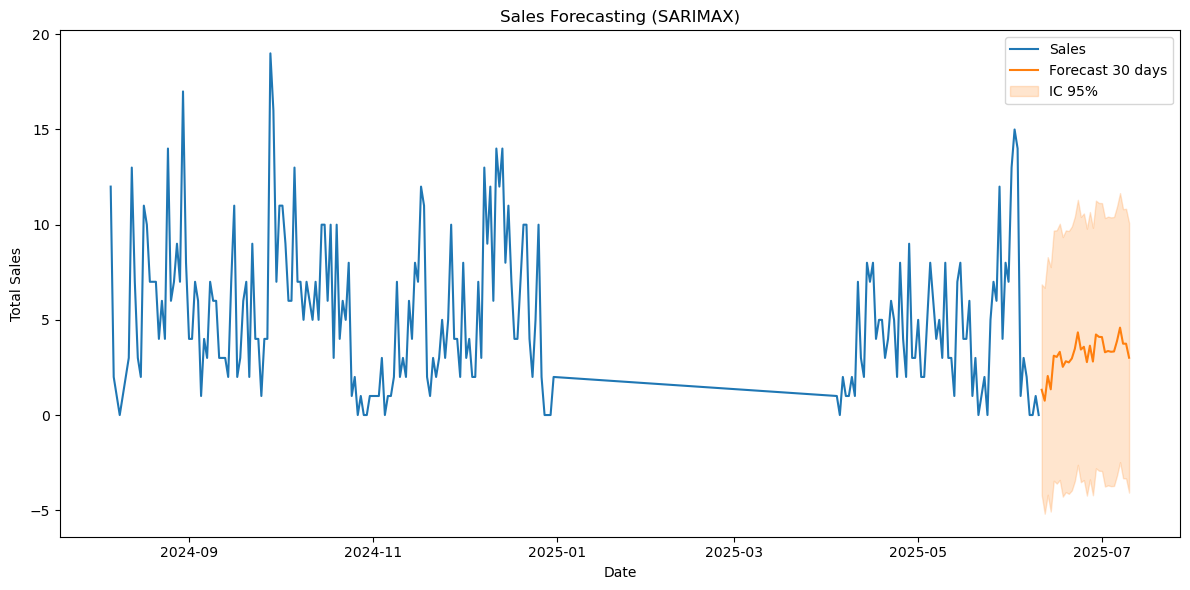

In [15]:
import matplotlib.pyplot as plt

# We start from what was calculated before:
# df = combined_final with datetime index
# train = df.loc[~df['ignore']] (series used for training)
# pred = forecast.predicted_mean (forecast series)
# forecast = get_forecast result object (for CI bands)
# conf_int = forecast.conf_int()

# 1. Also obtain the confidence intervals
conf_int = forecast.conf_int(alpha=0.05)  # 95%

# 2. Graph
plt.figure(figsize=(12,6))

# Historical
plt.plot(train.index, train['total_sales'], label='Sales', color='C0')

# Forecast
plt.plot(pred.index, pred, label='Forecast 30 days', color='C1')

# Conficence Intervals
plt.fill_between(conf_int.index,
                 conf_int['lower total_sales'],
                 conf_int['upper total_sales'],
                 color='C1', alpha=0.2,
                 label='IC 95%')

plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.title('Sales Forecasting (SARIMAX)')
plt.legend()
plt.tight_layout()
plt.show()

/Users/anapaulaelizondo/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/anapaulaelizondo/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/anapaulaelizondo/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/anapaulaelizondo/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information an

/Users/anapaulaelizondo/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/anapaulaelizondo/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/anapaulaelizondo/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/anapaulaelizondo/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer

/Users/anapaulaelizondo/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/anapaulaelizondo/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/anapaulaelizondo/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/anapaulaelizondo/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer

MAE: 3.21, RMSE: 3.78
Coverage 20–80%: 50.00%
Coverage 95%: 93.33%


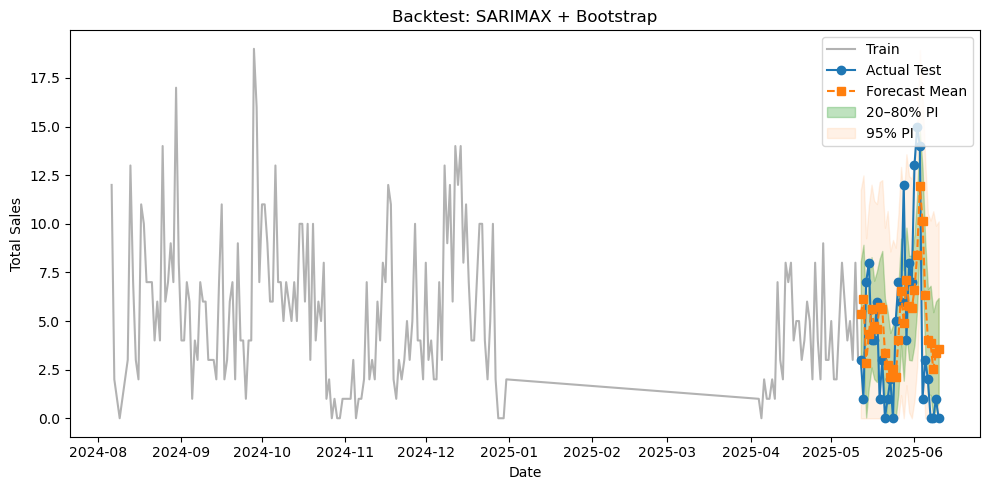

In [17]:
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

df = combined_final.copy()
df.index = pd.to_datetime(df.index)
df['total_sales'] = pd.to_numeric(df['total_sales'], errors='coerce')
df['ignore']      = df['ignore'].astype(bool)

# 1. Divide into train/test (last 30 days for testing)
series     = df.loc[~df['ignore'], 'total_sales']
h_test     = 30
train_full = series.iloc[:-h_test]
test       = series.iloc[-h_test:]

#2. SARIMA Parameters
order          = (2,0,2)
seasonal_order = (0,1,1,7)

# 3. Bootstrap simulations
nsim = 500

#4. Arrays to save results
pred_mean = []
p20_list   = []
p80_list   = []
p2_5_list  = []
p97_5_list = []

# 5. Back-test day by day
for i in range(h_test):
    # 5.1 Incremental training
    train_i = pd.concat([train_full, test.iloc[:i]])
    
    # 5.2 SARIMA adjusted
    model = SARIMAX(train_i,
                    order=order,
                    seasonal_order=seasonal_order,
                    enforce_stationarity=False,
                    enforce_invertibility=False)
    fit_i = model.fit(disp=False)
    
    # 5.3 forecast 1 
    fc = fit_i.get_forecast(steps=1)
    mu = fc.predicted_mean.iloc[0]
    
    # 5.4 bootstrap residuals + cut in 0
    resid = fit_i.resid.dropna().values
    sims  = np.random.choice(resid, size=(nsim,), replace=True) + mu
    sims  = np.clip(sims, 0, None)
    
    # 5.5 percentiles:20–80 for center band, 2.5–97.5 for end
    p20, p80    = np.percentile(sims, [20, 80])
    p2_5, p97_5 = np.percentile(sims, [3, 97])
    
    # 5.6 store
    pred_mean.append(mu)
    p20_list.append(p20)
    p80_list.append(p80)
    p2_5_list.append(p2_5)
    p97_5_list.append(p97_5)

# 6. Organize results in DataFrame
results = pd.DataFrame({
    'actual':  test.values,
    'mean_fc': pred_mean,
    'p20':     p20_list,
    'p80':     p80_list,
    'p2.5':    p2_5_list,
    'p97.5':   p97_5_list,
}, index=test.index)

# 7. Error metrics
mae   = mean_absolute_error(results['actual'], results['mean_fc'])
rmse  = np.sqrt(mean_squared_error(results['actual'], results['mean_fc']))

# Interval coverage
cov_20_80 = ((results.actual >= results.p20) & (results.actual <= results.p80)).mean()
cov_95    = ((results.actual >= results['p2.5']) & (results.actual <= results['p97.5'])).mean()

print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")
print(f"Coverage 20–80%: {cov_20_80:.2%}")
print(f"Coverage 95%: {cov_95:.2%}")

# 8. Comparative graph
plt.figure(figsize=(10,5))
plt.plot(train_full.index, train_full, color='gray', alpha=0.6, label='Train')
plt.plot(results.index, results['actual'], 'o-', label='Actual Test')
plt.plot(results.index, results['mean_fc'], 's--', label='Forecast Mean')

# 20–80%
plt.fill_between(results.index, results.p20, results.p80,
                 color='C2', alpha=0.3, label='20–80% PI')

# 95%
plt.fill_between(results.index, results['p2.5'], results['p97.5'],
                 color='C1', alpha=0.1, label='95% PI')

plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.title('Backtest: SARIMAX + Bootstrap')
plt.legend()
plt.tight_layout()
plt.show()

/var/folders/fb/m286qmnn2d9dg79tr96r4_rc0000gn/T/ipykernel_3985/1372736074.py:11: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sales = sales.asfreq('D').fillna(method='ffill')


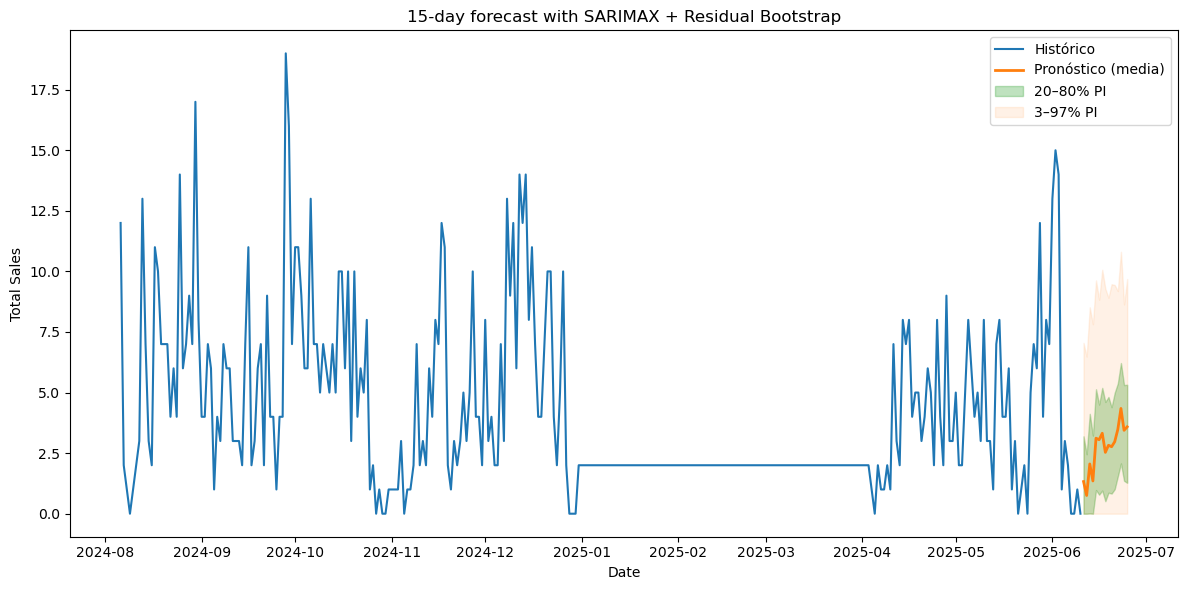

             mean_fc       p20       p80   p3        p97
2025-06-11  1.326423  0.000000  3.193825  0.0   7.048014
2025-06-12  0.751860  0.000000  2.453001  0.0   6.484733
2025-06-13  2.053390  0.012832  4.121688  0.0   8.519525
2025-06-14  1.351869  0.000000  3.225566  0.0   7.819191
2025-06-15  3.116424  0.975964  5.136701  0.0   9.628228
2025-06-16  3.052649  0.784767  4.503291  0.0   8.830899
2025-06-17  3.319231  0.957138  5.193645  0.0  10.068007
2025-06-18  2.531997  0.515695  4.610950  0.0   9.285307
2025-06-19  2.824825  0.868383  4.817250  0.0   8.914919
2025-06-20  2.763963  0.831685  4.394470  0.0   9.472667
2025-06-21  2.971102  1.013299  4.991378  0.0   9.437236
2025-06-22  3.479898  1.543270  5.378609  0.0   9.190092
2025-06-23  4.344140  2.076258  6.218555  0.0  10.810275
2025-06-24  3.440650  1.359122  5.308052  0.0   8.639186
2025-06-25  3.585547  1.274296  5.322500  0.0   9.686922


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

#1. Prepare the historical series without the rows marked as ignore
df = combined_final.copy()
df.index = pd.to_datetime(df.index)
sales = df.loc[~df['ignore'], 'total_sales'].astype(float)
# Rellenar huecos si los hubiera (opcional)
sales = sales.asfreq('D').fillna(method='ffill')

# 2. Adjust your final SARIMAX over the entire series
model = SARIMAX(
    sales,
    order=(2,0,2),
    seasonal_order=(0,1,1,7),
    enforce_stationarity=False,
    enforce_invertibility=False
)
fit = model.fit(disp=False)

# 3. Average forecast for the next 15 days
horizon = 15
fc = fit.get_forecast(steps=horizon)
mean_fc = fc.predicted_mean

# 4. Bootstrap residuals to create uncertainty bands
resid = fit.resid.dropna().values
nsim  = 500

# We simulate nsim trajectories of length `horizon`
sims = np.zeros((horizon, nsim))
for i in range(nsim):
    eps = np.random.choice(resid, size=horizon, replace=True)
    sims[:, i] = mean_fc.values + eps
# prevent negative sales
sims = np.clip(sims, 0, None)

# 5. Calculate central and extreme percentiles
p20   = np.percentile(sims, 20, axis=1)
p80   = np.percentile(sims, 80, axis=1)
p3    = np.percentile(sims, 3,  axis=1)
p97   = np.percentile(sims, 97, axis=1)

# 6. Assemble a DataFrame with the forecast
future_dates = pd.date_range(start=sales.index[-1] + pd.Timedelta(days=1),
                             periods=horizon, freq='D')
forecast_df = pd.DataFrame({
    'mean_fc':   mean_fc.values,
    'p20':       p20,
    'p80':       p80,
    'p3':        p3,
    'p97':       p97
}, index=future_dates)

# 7. History graph + forecast + bands
plt.figure(figsize=(12,6))
# Historic
plt.plot(sales.index, sales, color='C0', label='Histórico')

# Average forecast
plt.plot(future_dates, forecast_df['mean_fc'], color='C1', lw=2, label='Pronóstico (media)')

#  20–80%
plt.fill_between(future_dates,
                 forecast_df['p20'],
                 forecast_df['p80'],
                 color='C2', alpha=0.3, label='20–80% PI')

#  3–97%
plt.fill_between(future_dates,
                 forecast_df['p3'],
                 forecast_df['p97'],
                 color='C1', alpha=0.1, label='3–97% PI')

plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.title('15-day forecast with SARIMAX + Residual Bootstrap')
plt.legend()
plt.tight_layout()
plt.show()

# 8. Display the forecast DataFrame
print(forecast_df)

In [20]:
# Name of the file you want to create
nombre_archivo = "combined_final.csv"

# We build the complete route
out_route = os.path.join(ruta_base, nombre_archivo)

# We save the DataFrame without the index
combined_final.to_csv(out_route, index=True, encoding="utf-8-sig")

print(f"File saved in: {out_route}")

File saved in: /Users/anapaulaelizondo/Desktop/Cosmos/data/combined_final.csv
